In [1]:
import torch
from torch.nn.functional import normalize

import clip
import cv2
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

from sqb.tools import extract_character, remove_empty_area

In [15]:
# clip.available_models()

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# backbone: str = 'ViT-B/16'
backbone: str = 'ViT-L/14'

model, preprocess = clip.load(backbone, device=device)

100%|███████████████████████████████████████| 890M/890M [00:44<00:00, 20.9MiB/s]


In [17]:
@torch.inference_mode()
def get_image_embedding(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    return normalize(model.encode_image(image), p=2.0)

In [18]:
def get_query_embedding(query_image_path):
    query_image = extract_character(query_image_path)
    query_image = remove_empty_area(query_image)
    cv2.imwrite('query.png', query_image)

    return get_image_embedding('query.png').reshape(1, -1)

def get_similar_images(query_image_path, top_k: int = 3):
    query_embedding = get_query_embedding(query_image_path)

    similarity = (100.0 * query_embedding @ documents_embeddings.T).softmax(dim=-1, dtype=torch.float32)

    _, indices = similarity[0].topk(top_k)
    indices = indices.cpu().numpy()

    top_images = [document_images[index] for index in indices]
    top_images.insert(0, 'query.png')

    return top_images

In [19]:
document_images = sorted(Path('character_images').glob('*/*.png'))

documents_embeddings = torch.cat([get_image_embedding(path) for path in tqdm(document_images)], dim=0)
documents_embeddings.shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:42<00:00, 13.09it/s]


torch.Size([560, 768])

In [20]:
top_k: int = 5

test_path = r'C:\\Users\zero\Pictures\MapleStory Worlds'

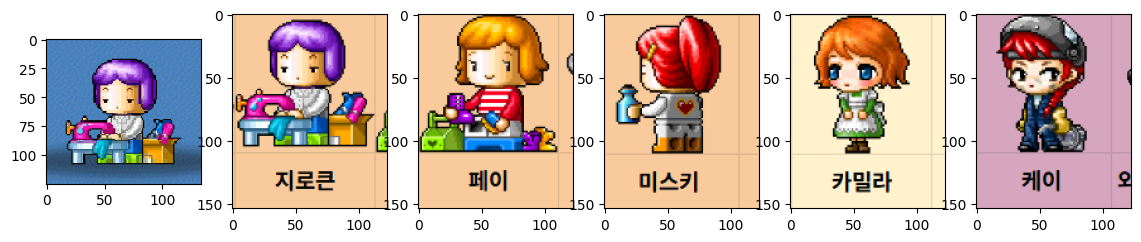

CPU times: total: 1.33 s
Wall time: 573 ms


In [21]:
%%time
test_images = sorted(Path(test_path).glob('*.png'), reverse=True)

fig = plt.figure(figsize=(14, 32))

top_images = get_similar_images(test_images[0], top_k=top_k)

for i, image in enumerate(top_images):
    fig.add_subplot(1, top_k + 1, i + 1)
    plt.imshow(cv2.imread(image)[..., ::-1])

plt.show()

# EOF

In [22]:
test_images = sorted(Path('tests').glob('*.png'), reverse=True)
test_images = sorted(Path(test_path).glob('*.png'), reverse=True)

results = []
for test_image in test_images:
    results.extend([
        cv2.imread(path)[..., ::-1]
        for path in get_similar_images(test_image, top_k=top_k)
    ])

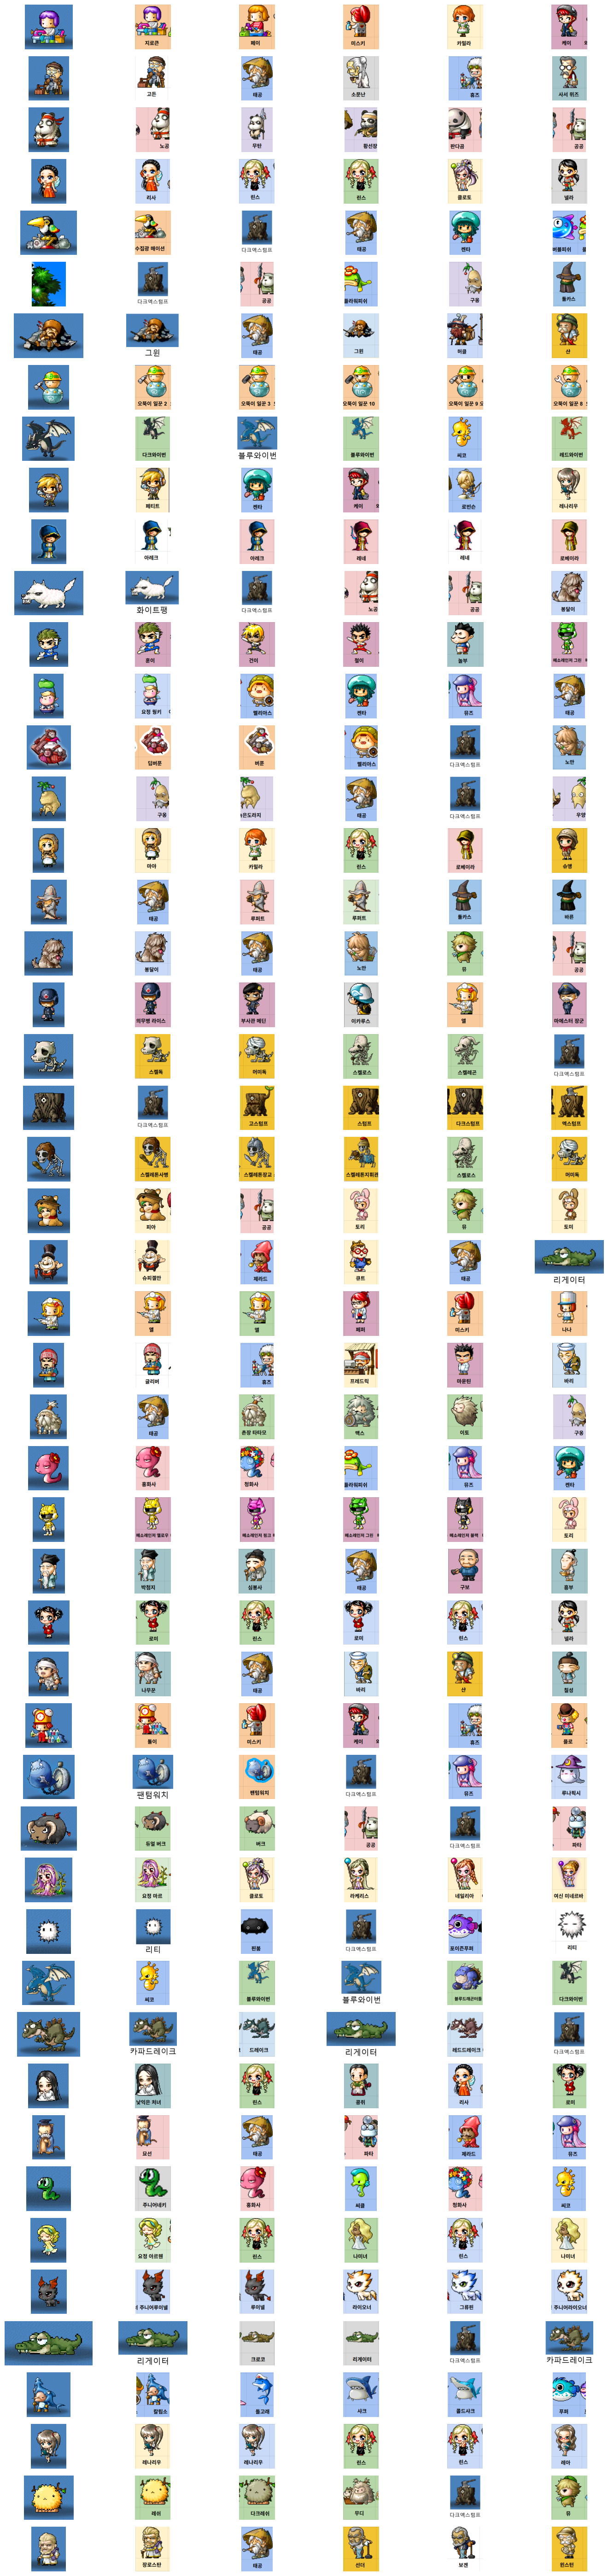

In [23]:
fig, axes = plt.subplots(len(test_images), top_k + 1, figsize=(14, 56))

for idx, ax in enumerate(axes.flat):
    ax.imshow(results[idx])
    ax.axis('off')

plt.tight_layout()
plt.show()

# EOF